<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Crear_Modelo_AWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
!pip install -q efficientnet
!pip install -q awscli

import tensorflow as tf
import efficientnet.tfkeras as efn
from keras.models import load_model
import tarfile
import os

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/TFG/')

from TFG_Comun import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carga del modelo

In [2]:
# Carga del modelo
model = load_model(TFG_MODEL)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b5 (Functional  (None, 2048)             28513520  
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 classify (Dense)            (None, 1)                 2049      
                                                                 
Total params: 28,515,569
Trainable params: 28,342,833
Non-trainable params: 172,736
_________________________________________________________________


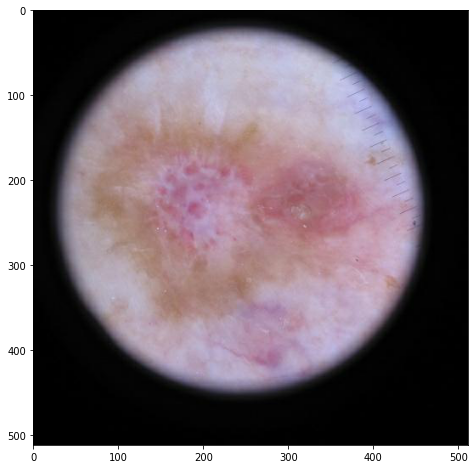

[0.6330868]


In [9]:
# Ejemplo de predicción con el modelo
import PIL
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(8, 8))
image = PIL.Image.open("/content/drive/MyDrive/TFG/ISIC/Melanoma/ISIC_0055709.jpg")
plt.imshow(image)
plt.show()
tensor = tf.keras.utils.img_to_array(image)
tensor = tf.expand_dims(tensor,0)
prediction = model.predict(tensor, verbose=0).flatten()
print(prediction)

## Preparación del modelo en formato TensorFlow ProtoBuf 

In [10]:
!mkdir -p export/Servo/

# Atención: se debe seguir esta estructura
model_version = '1'
export_dir = 'export/Servo/' + model_version
model.save(export_dir)

#!cp {TFG_MODEL_INFERENCE} export/code/

In [11]:
# Se copia el tarball del modelo a Google Drive 
model_archive = TFG_MODEL_AWS
model_archive_back = model_archive + ".back"
!mv {model_archive} {model_archive_back}
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('export', recursive=True) 

In [12]:
# Se copia el tarball del modelo a AWS S3
!export AWS_SHARED_CREDENTIALS_FILE={TFG_AWS_CREDENTIALS}
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = TFG_AWS_CREDENTIALS
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])
!aws s3 mv {TFG_MODEL_AWS_S3} {TFG_MODEL_AWS_S3}.back 
!aws s3 cp {TFG_MODEL_AWS} {TFG_MODEL_AWS_S3}
!aws s3 ls {TFG_AWS_BUCKET} --recursive --human-readable --summarize

/content/drive/MyDrive/TFG/awscli.ini
move: s3://uoc-tfg/TFG_mejor_modelo.tar.gz to s3://uoc-tfg/TFG_mejor_modelo.tar.gz.back
upload: drive/MyDrive/TFG/TFG_mejor_modelo.tar.gz to s3://uoc-tfg/TFG_mejor_modelo.tar.gz
2023-01-11 22:41:06  300.5 MiB TFG_mejor_modelo.tar.gz
2023-01-11 22:41:03  186.5 MiB TFG_mejor_modelo.tar.gz.back
2022-12-10 21:54:44    0 Bytes isic2019-256x256/
2022-12-10 21:56:42    1.6 MiB isic2019-256x256/train.csv

Total Objects: 4
   Total Size: 488.6 MiB


Este notebook está inspirado por:
- Deploy trained Keras or TensorFlow models using Amazon SageMaker  
https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/
- Save and load models  
https://www.tensorflow.org/tutorials/keras/save_and_load